In [1]:
import re
import string
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Initialize spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [2]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.keep_words = {
            "not", "no", "never", "none",
            "can", "could", "may", "might", "must", "should",
            "all", "any", "some", "few", "many",
            "now", "soon", "immediately", "recently",
            "if", "unless", "until",
            "high", "critical", "low", "medium", "zero"
        }
        
        # Update stop words
        for word in self.keep_words:
            if word in STOP_WORDS:
                STOP_WORDS.remove(word)
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_text(self, text):
        doc = nlp(text)
        tokens = [
            token.lemma_.lower() 
            for token in doc 
            if not token.is_stop 
            and not token.is_punct 
            and token.is_alpha
            and len(token.lemma_) > 1
        ]
        return " ".join(tokens)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.Series):
            return X.apply(lambda x: self.preprocess_text(self.clean_text(x)))
        elif isinstance(X, np.ndarray):
            return np.array([self.preprocess_text(self.clean_text(text)) for text in X])
        elif isinstance(X, str):
            return np.array([self.preprocess_text(self.clean_text(X))])
        else:
            raise ValueError("Input must be string, NumPy array, or Pandas Series")

In [67]:
df = pd.read_csv("Nigeria_Incident_Tracking.csv", encoding='latin1')  # or 'ISO-8859-1'


In [68]:
df = df.dropna()

In [71]:
# Assuming df is your DataFrame with text in column 4 and labels in column 3
X = df.iloc[:, 4]
y = df.iloc[:, 3]

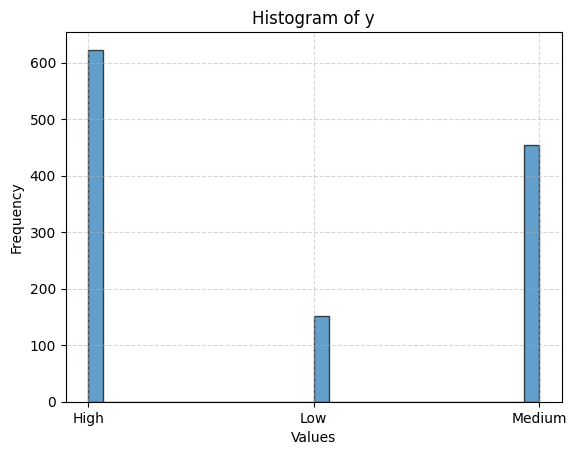

In [72]:
import matplotlib.pyplot as plt
import numpy as np  # Only needed if generating random data

# Example data (replace with your 'x')
# x = np.random.normal(0, 1, 1000)  # 1000 random numbers from a normal distribution

# Plot histogram
plt.hist(y, bins=30, edgecolor='black', alpha=0.7)
plt.title("Histogram of y")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [73]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

In [74]:
# Define the complete pipeline
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier())
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('classifier', RandomForestClassifier())])

In [75]:
# Predictions
y_pred = pipeline.predict(X_test)

# Metrics
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Side-by-side comparison
results = pd.DataFrame({
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(y_pred)
})
print(results.head(10))
X_test

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       125
           1       0.93      0.93      0.93        30
           2       0.92      0.96      0.94        91

    accuracy                           0.95       246
   macro avg       0.94      0.94      0.94       246
weighted avg       0.95      0.95      0.95       246

Confusion Matrix:
 [[118   1   6]
 [  0  28   2]
 [  3   1  87]]
   Actual Predicted
0    High      High
1  Medium    Medium
2    High      High
3    High      High
4    High      High
5    High      High
6  Medium    Medium
7     Low       Low
8    High    Medium
9    High      High


945    Bandits fired indiscriminately in Kwakware vil...
605    A mob attacked the Lafiyawo office of the Fede...
683    ISWAP insurgents with a VBIED attacked GSF per...
386    GSF personnel on clearance operations engaged ...
37     Gang members shot and killed a man in the Ijeu...
                             ...                        
793    There was a violent clash between members of t...
596    Bandits attacked communities around Tunga-Kawo...
176    Bandits attacked Dumfawa community in Zurmi LG...
122    GSF personnel conducted clearance operations a...
185    Unidentified armed men killed a police inspect...
Name: Incident Description, Length: 246, dtype: object

In [78]:
# Example 1: Single text prediction
single_text = "Clearance operations by police at kidnappers' hideouts on the hills surrounding Zone A and B, Apo resettlement, Abuja"
print("Prediction:", le.inverse_transform(pipeline.predict(single_text)))

# Example 2: NumPy array prediction
text_array = np.array([
  "Civil servants held a protest on the premises of a commercial bank in Sokoto North LGA, Sokoto State, over the bankas inability to pay their monthly salary saved there.",
  "Clearance operations by police at kidnappers' hideouts on the hills surrounding Zone A and B, Apo resettlement, Abuja",
  "Coalition: Abuja hotel cancels booking for unveiling venue, opposition politicians kick "
])
print("Predictions:", le.inverse_transform(pipeline.predict(text_array)))

Prediction: ['Medium']
Predictions: ['Low' 'Medium' 'Medium']
